# In this kernel, I'm showing how to approximate lung volume with trapezoidal rule and threshold-based per-slice lung area detection (inspired from https://www.kaggle.com/miklgr500/lung-volume-feature)

In [ ]:
import os

import numpy as np
import pandas as pd
import pydicom

from skimage.measure import label,regionprops
from skimage.segmentation import clear_border
from tqdm.notebook import tqdm 
from multiprocessing import Pool

import matplotlib.pyplot as plt

## What is Trapezoidal Rule ?

### Trapezoidal rule is a technique for approximating the definite integral.


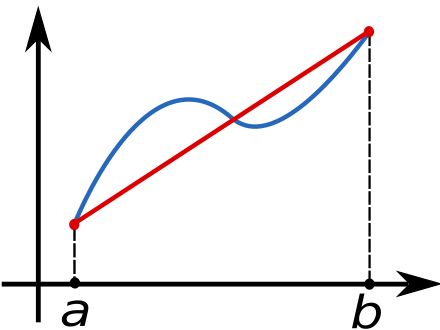

### In our case, the x-axis is the slice location (ImagePositionPatient[2] from dcm meta information), y-axis is the lung-area, applying trapezoidal method give as an approximate of lung volume

## Lung Volume Calculus

In [ ]:
class Detector:
    def __call__(self, x):
        raise NotImplementedError('Abstract') 
        
class ThrDetector(Detector):
    def __init__(self, thr=-400):
        self.thr = thr
        
    def __call__(self, x):
        try:
            x = pydicom.dcmread(x)
            img = x.pixel_array
            img = (img + x.RescaleIntercept) / x.RescaleSlope
            img = img < self.thr
            
            img = clear_border(img)
            img = label(img)
            areas = [r.area for r in regionprops(img)]
            areas.sort()
            if len(areas) > 2:
                for region in regionprops(img):
                    if region.area < areas[-2]:
                        for coordinates in region.coords:                
                            img[coordinates[0], coordinates[1]] = 0
                            
            area = (img > 0).sum() * x.PixelSpacing[0] * x.PixelSpacing[1] # scale the detected lung area according the the pixel spacing value
            
        except:
            area = np.nan

        try:
            loc = x.ImagePositionPatient[2]
        except:
            loc = np.nan

        return area, loc
  
class Integral:
    def __init__(self, detector: Detector):
        self.detector = detector
    
    def __call__(self, xs):
        raise NotImplementedError('Abstract')
        

class AreaIntegral(Integral):
    def __call__(self, xs):
        
        with Pool(4) as p:
            areas, locs = map(list, zip(*p.map(self.detector, xs) ))
        
        filt = (~np.isnan(locs)) & (~np.isnan(areas))
        areas = np.array(areas)[filt]
        locs = np.array(locs)[filt]
        seq_idx = np.argsort(locs)

        return np.trapz(y=areas[seq_idx], x=locs[seq_idx])/1000

In [ ]:
train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
train_data = {}
for p in train.Patient.values:
    train_data[p] = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')

In [ ]:
keys = list(train_data.keys()) #[k for k in list(train_data.keys()) if k not in ['ID00011637202177653955184', 'ID00052637202186188008618']]

In [ ]:
integral = AreaIntegral(ThrDetector()) 

In [ ]:
volume = {}
for k in tqdm(keys, total=len(keys)):
    x = []
    for i in train_data[k]:
        x.append(f'../input/osic-pulmonary-fibrosis-progression/train/{k}/{i}') 
    volume[k] = integral(x)

In [ ]:
for k in tqdm(train.Patient.values):
    #if k in ['ID00011637202177653955184', 'ID00052637202186188008618']:
    #    continue
    train.loc[train.Patient == k,'v'] = volume[k]

In [ ]:
plt.figure(figsize=(10, 10))
plt.xlabel('v')
plt.ylabel('FVC')
plt.plot(train.v, train.FVC, '.')

In [ ]:
train[['v', 'FVC']].corr('spearman')

## Some Observations and Conclusions

1. As we could see, most of time, when lung volume increases, the FVC increases as well (High spearman\ranking correlations)
2. For **straight lines**, they are from the same patient, but the FVC is taken at different timing
3. However, there are some outliers need to be further investigated

In [ ]:
pd.to_pickle(volume, 'patient_lung_volume.pkl') # for readers to integrate with their modeling :D